# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [7]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.0.0


# Preparing Training and Test Sets

In [8]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [9]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):   #pass the image directories for the 3 classes and transform object for data augmentation for the training set
        def get_images(class_name):   
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]    #the 'image_dir' will be a dict wihch will have path for the three training directories
            print(f'Found {len(images)} {class_name} samples')                                      # get the path for corresponding class, using class_name argument that we are passing
            return images
        
        self.images = {}      # use a dict to store the images for different classes
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:          #iterate over the 3 class names 
            self.images[c] = get_images(c)  #get the list of images for the class being iterated
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):        #function that returns the length of the dataset ie., no of images for all 3 classes
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):                       
        class_name = random.choice(self.class_names)    #since we have class imbalance, we use the remainder of the index divided by the no. of images we have for that class (proportionate)
        index = index % len(self.images[class_name])    #since index can be out of bounds for some of the images of a class, we take the mod of the index with total no. of images in that class 
        image_name = self.images[class_name][index]     #get the name of the image matching the index
        image_path = os.path.join(self.image_dirs[class_name], image_name)  #join the image_dir path and image name to get the full path of image
        image = Image.open(image_path).convert('RGB')   #convert the b&w to RGB since we are using ResNET18 that has pre-trained weights(trained on imagenet dataset) and inputs are defined (3 channels)
        return self.transform(image), self.class_names.index(class_name)  #returns the transformed image

# Image Transformations

In [10]:
train_transform = torchvision.transforms.Compose([     #since we use pretrained resnet model we need to convert all images to the size the model expects
    torchvision.transforms.Resize(size = (224, 224)), 
    torchvision.transforms.RandomHorizontalFlip(),     #if we do a horizontal flip of a xray image, it doesn't make any difference for classification and can be used for augmentation
    torchvision.transforms.ToTensor(),                 #so that image can be used in computtation by PyTorch
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #normalize our input data in the same way that the imagenet dataset (used for training resnet18) was normalized
])

In [11]:
test_transform = torchvision.transforms.Compose([     #since we use pretrained resnet model we need to convert all images to the size the model expects
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),                 #so that image can be used in computtation by PyTorch
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #normalize our input data in the same way that the imagenet dataset (used for training resnet18) was normalized
])

# Prepare DataLoader

In [12]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)    #call the function with training directories and train transform

Found 1311 normal samples
Found 1315 viral samples
Found 189 covid samples


In [13]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)   #call the function with test directories and test transform

Found 30 normal samples
Found 30 viral samples
Found 30 covid samples


In [14]:
batch_size = 6

#dataloader for training samples. The indices are shuffled and the samples are not picked in sequence
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)   

#dataloader for test samples
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

#no. of batches that are created from train and test sets
print('No. of training batches', len(dl_train))
print('No. of test batches', len(dl_test))


No. of training batches 470
No. of test batches 15


# Data Visualization

In [15]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])      # 1 row and 6 columns (so 6 images). Index for subplot starts from 1, so i+1
        
        # convert the image tensor (from dataloader) to numpy and transpose in a way where the first axis should be last one. In resnet the input is {channel, height, width}
        image = image.numpy().transpose((1, 2, 0))    
        
        mean = np.array([0.485, 0.456, 0.406])              
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean                          # convert the image pixel values to original values before the normalization of images in the dataloaders
        image = np.clip(image, 0., 1.)
        plt.imshow(image)                                   # display image
        
        # prediction is displayed in green if it is correct, else in red
        col = 'green' if preds[i] == labels[i] else 'red' 
        
        # x-label for groud truth and y-label for prediction.
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()
        

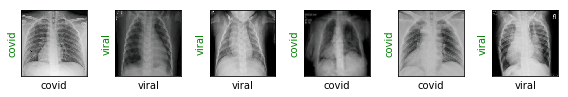

In [16]:
images, labels = next(iter(dl_train))         #fetch the next batch of 6 samples
show_images(images, labels, labels)           #since we don't have preds yet, pass labels 

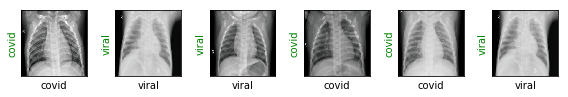

In [17]:
images, label = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [18]:
resnet18 = torchvision.models.resnet18(pretrained=True)  # use the pretrained weights from the Imagenet training
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Ganesh/.torch\models\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████| 46827520/46827520 [00:05<00:00, 8541045.00it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [24]:
# since there are only 3 classes to classify (normal,viral,covid), the out_features for the last fc is changed to 3
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)  
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5) 

In [25]:
def show_preds():
    resnet18.eval()                       #set the model to evaluation mode, that turns off specific layers/parts of model
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)      # get the indices that has the highest energy (the prediction) out of the 3 classes, for all images
    show_images(images, labels, preds)    

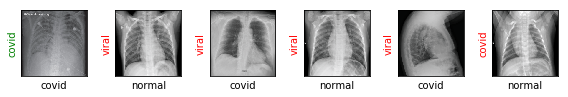

In [27]:
show_preds()                             # model is not trained on our dataset yet, so it just uses the pretrained weights here

# Training the Model

In [29]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1/epochs}')
        print('='*20)
        
        train_loss = 0.
        resnet18.train()                       # set the model training to true, which turns on the specific layers/parts of model that were turned off during eval()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()              # make gradient buffers as 0
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)    # apply loss function on predicted and ground truth values
            loss.backward()                    # backpropagate the loss
            optimizer.step()                   # gradient step that updates the model parameters
            train_loss += loss.item()
            
            if(train_step % 20 == 0):          # evaluate the model on the test set, once in every 20 steps (batches)
                print('Evaluating at step', train_step)
                acc = 0.                       # set accuracy to 0
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)      # get validation loss for each step
                acc = acc / len(test_dataset)   # the no. of samples which were predicted correct/total no. of samples in test set 
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance condition is satisfied!')
                    return
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
            

Starting training..
Starting epoch 1.0
Evaluating at step 0
Val loss: 1.2483, Acc: 0.2667


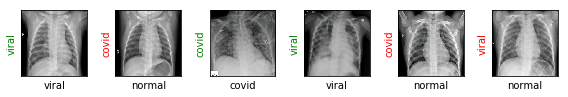

Evaluating at step 20
Val loss: 0.6630, Acc: 0.8111


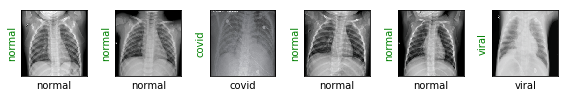

Evaluating at step 40
Val loss: 0.3132, Acc: 0.8778


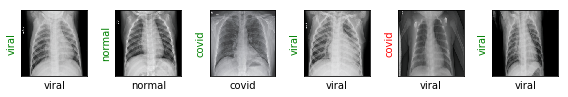

Evaluating at step 60
Val loss: 0.1716, Acc: 0.9556


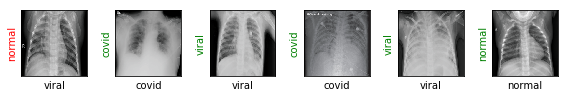

Performance condition is satisfied!


In [30]:
train(epochs=1)

# Final Results

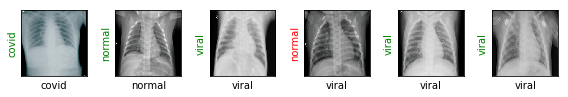

In [35]:
show_preds()         #this time the model is trained up to 60 steps and performs much better on the test set.